In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from dataclasses import dataclass
from tqdm.auto import tqdm
from IPython.display import display, clear_output

In [14]:
# Load the data
R = 1100 # 800, 850, 1000, 1100, 1200
df1 = pd.read_csv(f'./cutting/r{R}.csv', header=None)
df1.columns = ["width", "height", "value"]

df2 = df1.copy()
df2["width"], df2["height"] = df2["height"], df2["width"]

data = pd.concat([df1, df2], ignore_index=True).reset_index(drop=True)

In [15]:
def calculate_bouding_angles(data, R):
    d_max = data["height"].min()
    max_theta = np.arcsin(d_max / (2 * R))
    return ((np.pi / 2) + max_theta, np.pi - max_theta)

alfa_min, alfa_max = calculate_bouding_angles(data, R)

def project_onto_circle(alfa, R):
    x = R * np.cos(alfa)
    y = R * np.sin(alfa)
    return x, y

In [16]:
class Rectangle():
    def __init__(self, x, y, type_id):
        self.width = data.loc[type_id, "width"]
        self.height = data.loc[type_id, "height"]
        self.value = data.loc[type_id, "value"]

        self.vertices = np.array([
            [x, y],
            [x + self.width, y],
            [x, y - self.height],
            [x + self.width, y - self.height]
        ])


    def fits_in_circle(self, R):
        v = np.linalg.norm(self.vertices, 2, axis=1) <= R
        return np.all(v)

    def __repr__(self):
        return f"Rectangle({self.width}, {self.height}, {self.value})"

In [17]:
from __future__ import annotations


@dataclass
class Genom:
    alfa: float
    types: list

    def guassian_mutation(self, sigma=0.1):
        """Uses gaussian mutation to mutate the alfa value of the genom."""
        noise = np.random.normal(0, sigma)
        alfa = np.clip(self.alfa + noise, alfa_min, alfa_max)
        return Genom(alfa, self.types)

    def change_type_mutation(self):
        """Changes the type of a random rectangle in the genom."""
        types = self.types.copy()
        idx = np.random.randint(len(types))
        types[idx] = np.random.randint(len(data))
        return Genom(self.alfa, types)

    def add_type_mutation(self):
        """Adds a random rectangle to the genom."""
        types = self.types.copy()
        types.append(np.random.randint(len(data)))
        return Genom(self.alfa, types)


@dataclass
class Individual:
    genom: Genom
    rectangles: list[Rectangle]

    @staticmethod
    def from_genom(genom: Genom):
        rectangles = []
        x, y = project_onto_circle(genom.alfa, R)

        included = []
        for i, type_id in enumerate(genom.types):

            x = -np.sqrt(R**2 - y**2)
            rect = Rectangle(x, y, type_id)

            if not rect.fits_in_circle(R):

                if R > np.abs(y - rect.height):
                    x = -np.sqrt(R**2 - (y - rect.height)**2)
                    rect = Rectangle(x, y, type_id)
                else:
                    break

            include = False
            while rect.fits_in_circle(R):
                rectangles.append(rect)
                include = True

                x += rect.width
                rect = Rectangle(x, y, type_id)

            if include:
                included.append(i)
                y -= rect.height

        genom.types = [genom.types[i] for i in included]

        return Individual(genom, rectangles)

    def fitness(self):
        return sum([rect.value for rect in self.rectangles])

    def plot(self):
        fig, ax = plt.subplots()
        
        circle = plt.Circle((0, 0), R, color='red', fill=False)
        ax.add_artist(circle)

        for rect in self.rectangles:
            ax.add_patch(plt.Rectangle(rect.vertices[2], rect.width, rect.height, edgecolor='blue', facecolor='none'))

        ax.set_xlim(-R, R)
        ax.set_ylim(-R, R)
        ax.set_aspect('equal', adjustable='datalim')
        return fig, ax

In [18]:
def get_parents(population: list[Individual], crossover_p: float = 0.7) -> tuple[list[Individual], list[Individual]]:
    """
    Split the population into two groups of parents
    """
    prob_vector = np.random.random(len(population))
    reproductive_population = [
        population[i] for i in range(len(population)) if prob_vector[i] < crossover_p
    ]
    idx = np.arange(len(reproductive_population))
    np.random.shuffle(idx)
    reproductive_population2 = [
        reproductive_population[i] for i in idx
    ]
    split_idx = len(reproductive_population2) // 2
    return reproductive_population2[:split_idx], reproductive_population2[split_idx:(2*split_idx)]

In [19]:
def mutate(individual: Individual, mutation_p: float = 0.3) -> Individual:
    """
    Mutate the individual with probability mutation_p
    """
    if np.random.random() < mutation_p:
        mutation = np.random.choice(
            [Genom.guassian_mutation, Genom.change_type_mutation, Genom.add_type_mutation],
            p=[0.2, 0.3, 0.5]
        )
        genom = mutation(individual.genom)
        return Individual.from_genom(genom)
    return individual

In [20]:
def crossover(ind1: Individual, ind2: Individual) -> Individual:
    """Performs crossover between two individuals."""
    genom1, genom2 = ind1.genom, ind2.genom
    alfa = genom1.alfa
    types = []
    for t1, t2 in zip(genom1.types, reversed(genom2.types)):
        types.append(t1)
        types.append(t2)
    genom = Genom(alfa, types)
    ind = Individual.from_genom(genom)
    return ind

In [21]:
def elitism_selection(population: list[Individual], target_n: int, percentage: float = 0.15) -> list[Individual]:
    """Selects the n best individuals from the population."""
    n = int(len(population) * percentage)
    sorted_population = sorted(population, key=lambda x: x.fitness(), reverse=True)

    population = sorted_population[:n]
    left_over_population = sorted_population[n:]
    while len(population) < target_n:
        probs = np.array([ind.fitness() for ind in left_over_population])
        probs = probs / probs.sum()
        idx = np.random.choice(len(left_over_population), p=probs)
        ind = left_over_population.pop(idx)
        population.append(ind)

    return population

In [22]:
def random_individual() -> Individual:
    alfa = np.random.uniform(alfa_min, alfa_max)
    types = [np.random.randint(len(data))]
    return Individual.from_genom(Genom(alfa, types))

In [23]:
POPULATION_SIZE = 30
population = []
while len(population) < POPULATION_SIZE:
    ind = random_individual()
    if len(ind.rectangles) > 0:
        population.append(ind)

N_GENERATIONS = 200
pbar = tqdm(range(N_GENERATIONS))
for _ in pbar:

    parents1, parents2 = get_parents(population)

    children = []
    for p1, p2 in zip(parents1, parents2):
        child = crossover(p1, p2)
        child = mutate(child)
        children.append(child)
    
    # Mutated children without rectanges will have score of 0 and will be removed
    population = elitism_selection(population + children, POPULATION_SIZE)

    best_individual = max(population, key=lambda x: x.fitness())
    best_fitness = best_individual.fitness()

    pbar.set_postfix({
        "pop": len(population),
        "fit": best_fitness
    })

    # fig, ax = best_individual.plot()
    # plt.title(f"R: {R}, Fitness: {best_fitness}")
    # display(fig)
    # clear_output(wait = True)



  0%|          | 0/200 [00:00<?, ?it/s]

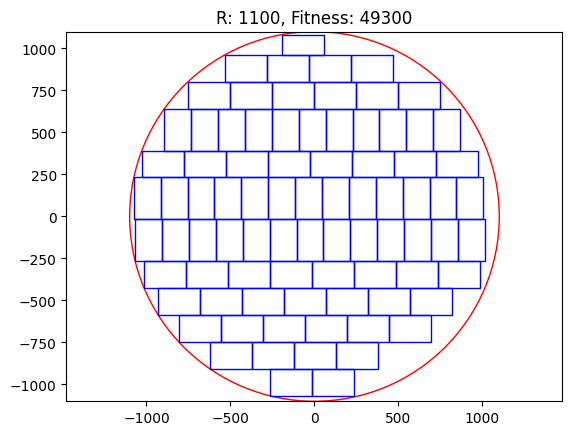

In [24]:
fig, ax = best_individual.plot()
plt.title(f"R: {R}, Fitness: {best_fitness}")
plt.show()